In [0]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
sns.set(font_scale=1.5) 

import cv2
from PIL import Image
from tqdm import tqdm_notebook as tqdm

import scipy

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import cohen_kappa_score, accuracy_score

from IPython.display import clear_output, FileLink


import keras
from keras import backend as K
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam, RMSprop
from keras import layers


print(os.listdir('../input/'))
%matplotlib inline

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

SIZE = 456
BATCH_SIZE = 4

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

['aptos2019densenet-mytrain', 'aptos2019-blindness-detection', 'efficientnetb5']


/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

# Load data

In [0]:
train_df = pd.read_csv('../input/aptos2019densenet-mytrain/new_train.csv')
test_df = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')
print(train_df.shape)
print(test_df.shape)
train_df.head()

(2856, 2)
(1928, 1)


,id_code,diagnosis
0,8aab201c0691,2
1,a45c30da0c72,0
2,e13412678eff,3
3,ab32db41c409,0
4,419406328dcd,2


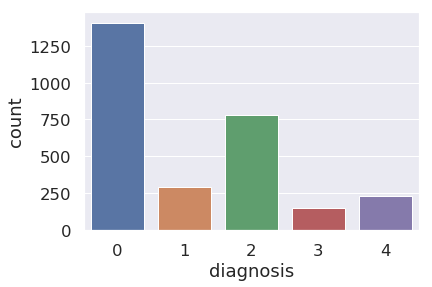

In [0]:
sns.countplot(train_df['diagnosis'])

In [0]:
# rename
train_df['id_code'] = train_df['id_code']+'.png'
test_df['id_code'] = test_df['id_code']+'.png'

In [0]:
train_df.head()

,id_code,diagnosis
0,8aab201c0691.png,2
1,a45c30da0c72.png,0
2,e13412678eff.png,3
3,ab32db41c409.png,0
4,419406328dcd.png,2


# Pre-processing

In [0]:
# train_path = '../input/aptos2019-blindness-detection/train_images'
# test_path =  '../input/aptos2019-blindness-detection/test_images'

# for preprocessing image directory
train_path = '../preprocess_train'
test_path = '../preprocess_test'

In [0]:
if (os.path.isdir(train_path) == False):
    os.mkdir(train_path)

if (os.path.isdir(test_path) == False):
    os.mkdir(test_path)

In [0]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

In [0]:
def normalizeimage(img):

    tmp = img.copy()
    tmp = cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB)
    tmp = crop_image_from_gray(tmp)
    tmp = cv2.resize(tmp, (SIZE,SIZE))
    
    return tmp

In [0]:
def preprocess_image(image_path, imtype, name):
    im = cv2.imread(os.path.join(image_path, name))
    im = normalizeimage(im)
    if imtype == 'train':
        cv2.imwrite(os.path.join(train_path,name), im)  # save image
    elif imtype == 'test': 
        cv2.imwrite(os.path.join(test_path,name), im)

In [0]:
for i, image_id in enumerate(tqdm(train_df['id_code'])):
    preprocess_image(f'../input/aptos2019-blindness-detection/train_images/', 'train', image_id)
    
for i, image_id in enumerate(tqdm(test_df['id_code'])):
    preprocess_image(f'../input/aptos2019-blindness-detection/test_images/', 'test', image_id)

* Display images

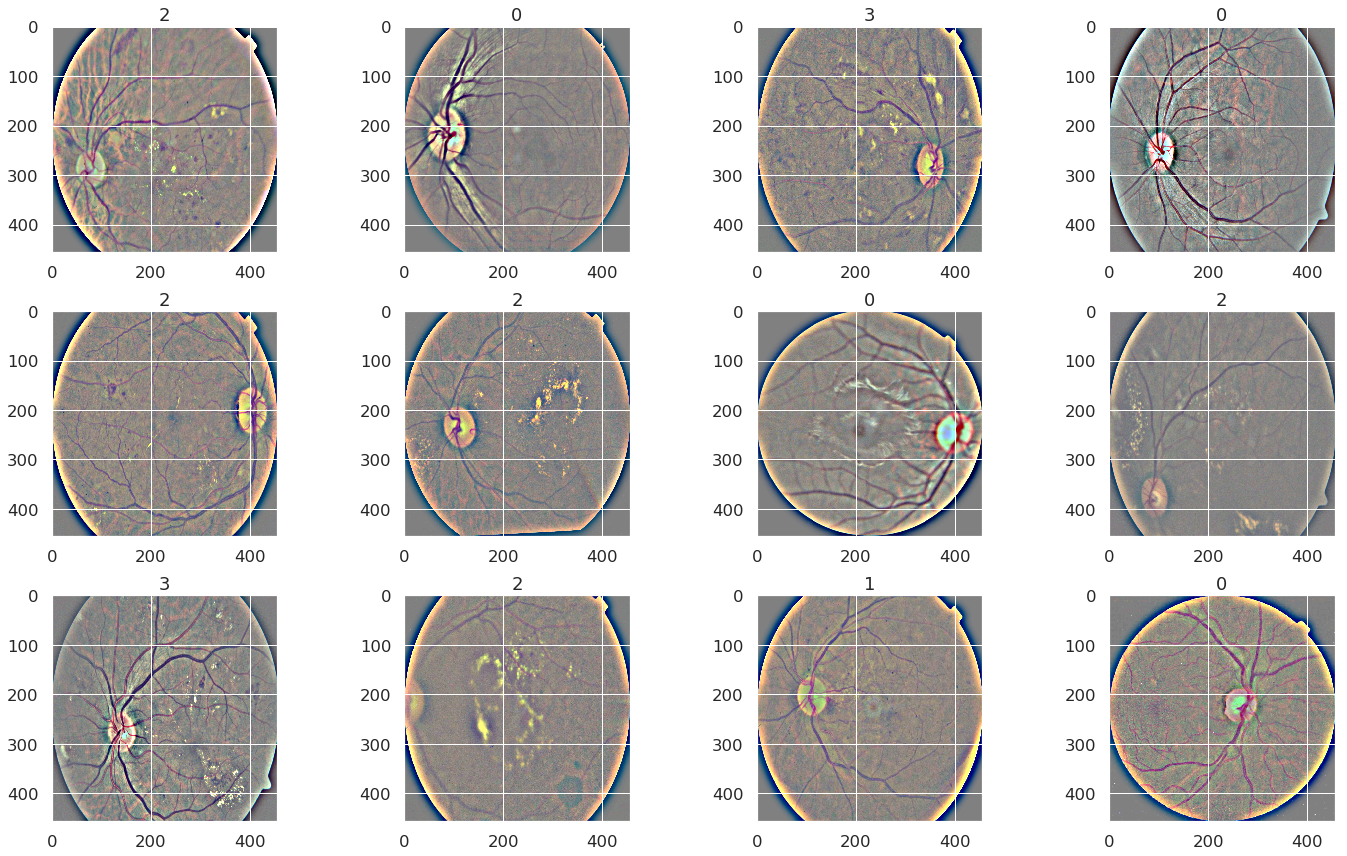

In [0]:
def display_samples(path, imgid, label, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows): 
        img = cv2.imread(os.path.join(path, f'{imgid[i]}'))
        img = cv2.addWeighted(img,4,cv2.GaussianBlur(img, (0,0), SIZE/50) ,-4 ,128)
#         img = cv2.addWeighted( img, 4, cv2.GaussianBlur( img , (0,0) , 10) ,-4 ,255//2)
        fig.add_subplot(rows, columns, i+1)
        plt.title(label[i])
        plt.imshow(img)
    
    plt.tight_layout()

display_samples(train_path, train_df['id_code'], train_df['diagnosis'])

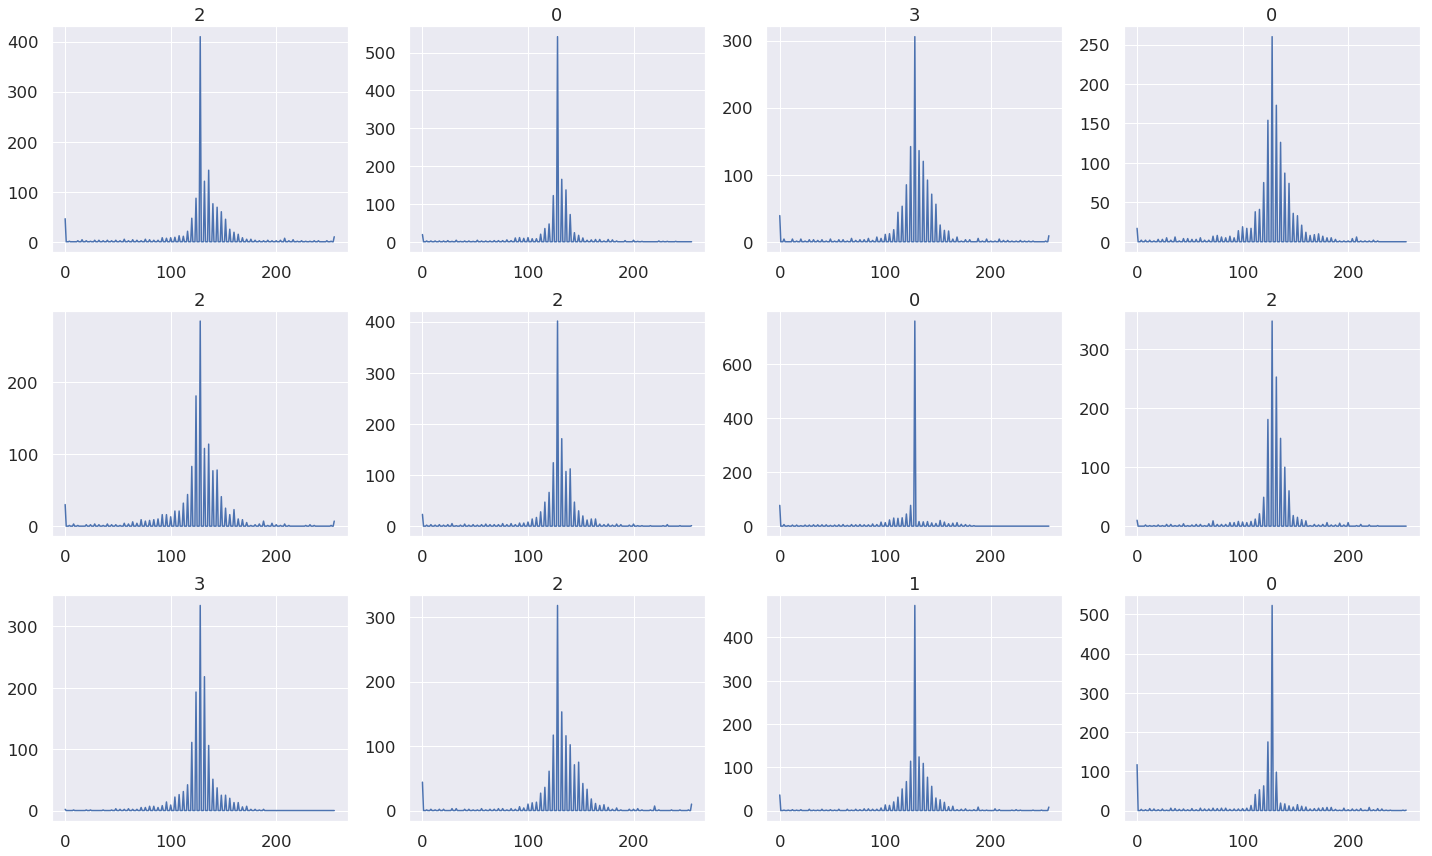

In [0]:
def display_histogram(path, imgid, label, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows): 
        img = cv2.imread(os.path.join(path, f'{imgid[i]}'))
        img = cv2.addWeighted(img,4,cv2.GaussianBlur(img, (0,0), SIZE/50) ,-4 ,128)
        hist = cv2.calcHist(img,[3],None,[256],[0,256])
        fig.add_subplot(rows, columns, i+1)
        plt.title(label[i])
        plt.plot(hist)
    
    plt.tight_layout()
    
display_histogram(train_path, train_df['id_code'], train_df['diagnosis'])

# Image Generator

In [0]:
def preprocess_input(img):
#     img = cv2.addWeighted( img, 4, cv2.GaussianBlur( img , (0,0) , 10) ,-4 ,255//2)
    img = cv2.addWeighted(img,4,cv2.GaussianBlur(img, (0,0), SIZE/50) ,-4 ,128)
    return img

In [0]:
def train_datagen():
    return ImageDataGenerator(rescale=1/128.,
                              rotation_range = 360,
#                               width_shift_range=0.1,
#                               height_shift_range=0.1,
#                               shear_range=0.10,
                              zoom_range=0.40,
                              fill_mode='nearest', #'constant',
#                               cval=255/2,
                              horizontal_flip=True,  # randomly flip images
                              vertical_flip=True, preprocessing_function=preprocess_input)

def val_datagen():
    return ImageDataGenerator(rescale=1/128., preprocessing_function=preprocess_input)

In [0]:
train_df['diagnosis'] = train_df['diagnosis'].astype('str')

In [0]:
X_train, X_val = train_test_split(train_df, stratify=train_df['diagnosis'], random_state=2019)
X_train.shape, X_val.shape

((2142, 2), (714, 2))

In [0]:
train_gen = train_datagen().flow_from_dataframe(dataframe=X_train,
                                                    directory=train_path,
                                                    x_col='id_code',
                                                    y_col='diagnosis',
                                                    target_size= (SIZE,SIZE),
                                                    color_mode='rgb',
                                                    class_mode='other',
                                                    batch_size=BATCH_SIZE,
                                                    seed=2019,
                                                   shuffle=True)
    

val_gen = val_datagen().flow_from_dataframe(dataframe=X_val,
                                                    directory=train_path,
                                                    x_col='id_code',
                                                    y_col='diagnosis',
                                                    target_size= (SIZE,SIZE),
                                                    color_mode='rgb',
                                                    class_mode='other',
                                                    batch_size=BATCH_SIZE,
                                                    seed=2019,
                                                    shuffle=True)

Found 2142 validated image filenames.
Found 714 validated image filenames.


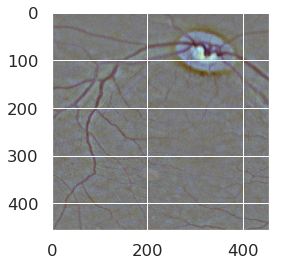

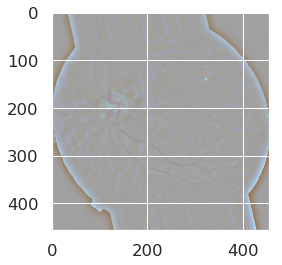

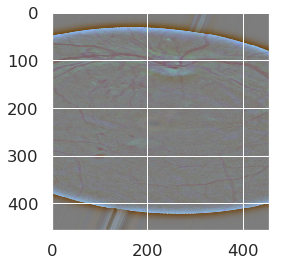

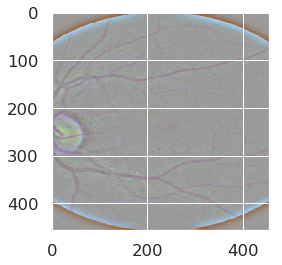

In [0]:
# 증식 결과 확인하기 

from keras.preprocessing import image
i = 0
for batch in train_gen:
        plt.figure(i)
#         print(batch[0][0].shape)
#         batch[0] = np.expand_dims(batch[0], axis=0)
        plt.imshow(image.array_to_img(batch[0][0]))
        i += 1
        if i%4 == 0 : break

# Modeling

In [0]:
from keras import initializers
from keras import regularizers
from keras import constraints
from keras.activations import elu
from keras.engine import Layer, InputSpec
from keras.utils.generic_utils import get_custom_objects

import tensorflow as tf

seed = 2019
np.random.seed(seed)
tf.set_random_seed(seed)

In [0]:

# custom metric with TF
def cohens_kappa(y_true, y_pred):
    y_true_classes = tf.argmax(y_true, 1)
    y_pred_classes = tf.argmax(y_pred, 1)
    
    return tf.contrib.metrics.cohen_kappa(y_true_classes, y_pred_classes, class_num)[1]

In [0]:
# Code Source: https://github.com/CyberZHG/keras-radam/blob/master/keras_radam/optimizers.py
class RAdam(keras.optimizers.Optimizer):
    """RAdam optimizer.
    # Arguments
        lr: float >= 0. Learning rate.
        beta_1: float, 0 < beta < 1. Generally close to 1.
        beta_2: float, 0 < beta < 1. Generally close to 1.
        epsilon: float >= 0. Fuzz factor. If `None`, defaults to `K.epsilon()`.
        decay: float >= 0. Learning rate decay over each update.
        weight_decay: float >= 0. Weight decay for each param.
        amsgrad: boolean. Whether to apply the AMSGrad variant of this
            algorithm from the paper "On the Convergence of Adam and
            Beyond".
        total_steps: int >= 0. Total number of training steps. Enable warmup by setting a positive value.
        warmup_proportion: 0 < warmup_proportion < 1. The proportion of increasing steps.
        min_lr: float >= 0. Minimum learning rate after warmup.
    # References
        - [Adam - A Method for Stochastic Optimization](https://arxiv.org/abs/1412.6980v8)
        - [On the Convergence of Adam and Beyond](https://openreview.net/forum?id=ryQu7f-RZ)
        - [On The Variance Of The Adaptive Learning Rate And Beyond](https://arxiv.org/pdf/1908.03265v1.pdf)
    """

    def __init__(self, lr=0.001, beta_1=0.9, beta_2=0.999,
                 epsilon=None, decay=0., weight_decay=0., amsgrad=False,
                 total_steps=0, warmup_proportion=0.1, min_lr=0., **kwargs):
        super(RAdam, self).__init__(**kwargs)
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.lr = K.variable(lr, name='lr')
            self.beta_1 = K.variable(beta_1, name='beta_1')
            self.beta_2 = K.variable(beta_2, name='beta_2')
            self.decay = K.variable(decay, name='decay')
            self.weight_decay = K.variable(weight_decay, name='weight_decay')
            self.total_steps = K.variable(total_steps, name='total_steps')
            self.warmup_proportion = K.variable(warmup_proportion, name='warmup_proportion')
            self.min_lr = K.variable(lr, name='min_lr')
        if epsilon is None:
            epsilon = K.epsilon()
        self.epsilon = epsilon
        self.initial_decay = decay
        self.initial_weight_decay = weight_decay
        self.initial_total_steps = total_steps
        self.amsgrad = amsgrad

    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        lr = self.lr

        if self.initial_decay > 0:
            lr = lr * (1. / (1. + self.decay * K.cast(self.iterations, K.dtype(self.decay))))

        t = K.cast(self.iterations, K.floatx()) + 1

        if self.initial_total_steps > 0:
            warmup_steps = self.total_steps * self.warmup_proportion
            decay_steps = self.total_steps - warmup_steps
            lr = K.switch(
                t <= warmup_steps,
                lr * (t / warmup_steps),
                lr * (1.0 - K.minimum(t, decay_steps) / decay_steps),
            )

        ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='m_' + str(i)) for (i, p) in enumerate(params)]
        vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='v_' + str(i)) for (i, p) in enumerate(params)]

        if self.amsgrad:
            vhats = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='vhat_' + str(i)) for (i, p) in enumerate(params)]
        else:
            vhats = [K.zeros(1, name='vhat_' + str(i)) for i in range(len(params))]

        self.weights = [self.iterations] + ms + vs + vhats

        beta_1_t = K.pow(self.beta_1, t)
        beta_2_t = K.pow(self.beta_2, t)

        sma_inf = 2.0 / (1.0 - self.beta_2) - 1.0
        sma_t = sma_inf - 2.0 * t * beta_2_t / (1.0 - beta_2_t)

        for p, g, m, v, vhat in zip(params, grads, ms, vs, vhats):
            m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
            v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(g)

            m_corr_t = m_t / (1.0 - beta_1_t)
            if self.amsgrad:
                vhat_t = K.maximum(vhat, v_t)
                v_corr_t = K.sqrt(vhat_t / (1.0 - beta_2_t) + self.epsilon)
                self.updates.append(K.update(vhat, vhat_t))
            else:
                v_corr_t = K.sqrt(v_t / (1.0 - beta_2_t) + self.epsilon)

            r_t = K.sqrt((sma_t - 4.0) / (sma_inf - 4.0) *
                         (sma_t - 2.0) / (sma_inf - 2.0) *
                         sma_inf / sma_t)

            p_t = K.switch(sma_t > 5, r_t * m_corr_t / v_corr_t, m_corr_t)

            if self.initial_weight_decay > 0:
                p_t += self.weight_decay * p

            p_t = p - lr * p_t

            self.updates.append(K.update(m, m_t))
            self.updates.append(K.update(v, v_t))
            new_p = p_t

            # Apply constraints.
            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)

            self.updates.append(K.update(p, new_p))
        return self.updates

    def get_config(self):
        config = {
            'lr': float(K.get_value(self.lr)),
            'beta_1': float(K.get_value(self.beta_1)),
            'beta_2': float(K.get_value(self.beta_2)),
            'decay': float(K.get_value(self.decay)),
            'weight_decay': float(K.get_value(self.weight_decay)),
            'epsilon': self.epsilon,
            'amsgrad': self.amsgrad,
            'total_steps': float(K.get_value(self.total_steps)),
            'warmup_proportion': float(K.get_value(self.warmup_proportion)),
            'min_lr': float(K.get_value(self.min_lr)),
        }
        base_config = super(RAdam, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [0]:
class GroupNormalization(Layer):
    """Group normalization layer
    Group Normalization divides the channels into groups and computes within each group
    the mean and variance for normalization. GN's computation is independent of batch sizes,
    and its accuracy is stable in a wide range of batch sizes
    # Arguments
        groups: Integer, the number of groups for Group Normalization.
        axis: Integer, the axis that should be normalized
            (typically the features axis).
            For instance, after a `Conv2D` layer with
            `data_format="channels_first"`,
            set `axis=1` in `BatchNormalization`.
        epsilon: Small float added to variance to avoid dividing by zero.
        center: If True, add offset of `beta` to normalized tensor.
            If False, `beta` is ignored.
        scale: If True, multiply by `gamma`.
            If False, `gamma` is not used.
            When the next layer is linear (also e.g. `nn.relu`),
            this can be disabled since the scaling
            will be done by the next layer.
        beta_initializer: Initializer for the beta weight.
        gamma_initializer: Initializer for the gamma weight.
        beta_regularizer: Optional regularizer for the beta weight.
        gamma_regularizer: Optional regularizer for the gamma weight.
        beta_constraint: Optional constraint for the beta weight.
        gamma_constraint: Optional constraint for the gamma weight.
    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
    # Output shape
        Same shape as input.
    # References
        - [Group Normalization](https://arxiv.org/abs/1803.08494)
    """

    def __init__(self,
                 groups=32,
                 axis=-1,
                 epsilon=1e-5,
                 center=True,
                 scale=True,
                 beta_initializer='zeros',
                 gamma_initializer='ones',
                 beta_regularizer=None,
                 gamma_regularizer=None,
                 beta_constraint=None,
                 gamma_constraint=None,
                 **kwargs):
        super(GroupNormalization, self).__init__(**kwargs)
        self.supports_masking = True
        self.groups = groups
        self.axis = axis
        self.epsilon = epsilon
        self.center = center
        self.scale = scale
        self.beta_initializer = initializers.get(beta_initializer)
        self.gamma_initializer = initializers.get(gamma_initializer)
        self.beta_regularizer = regularizers.get(beta_regularizer)
        self.gamma_regularizer = regularizers.get(gamma_regularizer)
        self.beta_constraint = constraints.get(beta_constraint)
        self.gamma_constraint = constraints.get(gamma_constraint)

    def build(self, input_shape):
        dim = input_shape[self.axis]

        if dim is None:
            raise ValueError('Axis ' + str(self.axis) + ' of '
                             'input tensor should have a defined dimension '
                             'but the layer received an input with shape ' +
                             str(input_shape) + '.')

        if dim < self.groups:
            raise ValueError('Number of groups (' + str(self.groups) + ') cannot be '
                             'more than the number of channels (' +
                             str(dim) + ').')

        if dim % self.groups != 0:
            raise ValueError('Number of groups (' + str(self.groups) + ') must be a '
                             'multiple of the number of channels (' +
                             str(dim) + ').')

        self.input_spec = InputSpec(ndim=len(input_shape),
                                    axes={self.axis: dim})
        shape = (dim,)

        if self.scale:
            self.gamma = self.add_weight(shape=shape,
                                         name='gamma',
                                         initializer=self.gamma_initializer,
                                         regularizer=self.gamma_regularizer,
                                         constraint=self.gamma_constraint)
        else:
            self.gamma = None
        if self.center:
            self.beta = self.add_weight(shape=shape,
                                        name='beta',
                                        initializer=self.beta_initializer,
                                        regularizer=self.beta_regularizer,
                                        constraint=self.beta_constraint)
        else:
            self.beta = None
        self.built = True

    def call(self, inputs, **kwargs):
        input_shape = K.int_shape(inputs)
        tensor_input_shape = K.shape(inputs)

        # Prepare broadcasting shape.
        reduction_axes = list(range(len(input_shape)))
        del reduction_axes[self.axis]
        broadcast_shape = [1] * len(input_shape)
        broadcast_shape[self.axis] = input_shape[self.axis] // self.groups
        broadcast_shape.insert(1, self.groups)

        reshape_group_shape = K.shape(inputs)
        group_axes = [reshape_group_shape[i] for i in range(len(input_shape))]
        group_axes[self.axis] = input_shape[self.axis] // self.groups
        group_axes.insert(1, self.groups)

        # reshape inputs to new group shape
        group_shape = [group_axes[0], self.groups] + group_axes[2:]
        group_shape = K.stack(group_shape)
        inputs = K.reshape(inputs, group_shape)

        group_reduction_axes = list(range(len(group_axes)))
        group_reduction_axes = group_reduction_axes[2:]

        mean = K.mean(inputs, axis=group_reduction_axes, keepdims=True)
        variance = K.var(inputs, axis=group_reduction_axes, keepdims=True)

        inputs = (inputs - mean) / (K.sqrt(variance + self.epsilon))

        # prepare broadcast shape
        inputs = K.reshape(inputs, group_shape)
        outputs = inputs

        # In this case we must explicitly broadcast all parameters.
        if self.scale:
            broadcast_gamma = K.reshape(self.gamma, broadcast_shape)
            outputs = outputs * broadcast_gamma

        if self.center:
            broadcast_beta = K.reshape(self.beta, broadcast_shape)
            outputs = outputs + broadcast_beta

        outputs = K.reshape(outputs, tensor_input_shape)

        return outputs

    def get_config(self):
        config = {
            'groups': self.groups,
            'axis': self.axis,
            'epsilon': self.epsilon,
            'center': self.center,
            'scale': self.scale,
            'beta_initializer': initializers.serialize(self.beta_initializer),
            'gamma_initializer': initializers.serialize(self.gamma_initializer),
            'beta_regularizer': regularizers.serialize(self.beta_regularizer),
            'gamma_regularizer': regularizers.serialize(self.gamma_regularizer),
            'beta_constraint': constraints.serialize(self.beta_constraint),
            'gamma_constraint': constraints.serialize(self.gamma_constraint)
        }
        base_config = super(GroupNormalization, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

## Pre-train Model
* EfficientNetB5

### Image SIZE for each model
* EfficientNetB0 - (224, 224, 3)
* EfficientNetB1 - (240, 240, 3)
* EfficientNetB2 - (260, 260, 3)
* EfficientNetB3 - (300, 300, 3)
* EfficientNetB4 - (380, 380, 3)
* **EfficientNetB5 - (456, 456, 3)**
* EfficientNetB6 - (528, 528, 3)
* EfficientNetB7 - (600, 600, 3)

In [0]:
os.listdir('../input/efficientnetb5/')

['efficientnet-master',
 'efficientnet-keras-weights',
 'efficientnet-b5_notop.h5']

In [0]:
# !pip install keras_efficientnets

import sys

# Repository source: https://github.com/qubvel/efficientnet
sys.path.append(os.path.abspath('../input/efficientnetb5/efficientnet-master/efficientnet-master/'))

from efficientnet import EfficientNetB5

In [0]:
def build_model():
    effnet = EfficientNetB5(input_shape=(SIZE,SIZE,3),
                            weights=None,
                            include_top=False)
    
    effnet.load_weights('../input/efficientnetb5/efficientnet-b5_notop.h5')
    
    # Replace all Batch Normalization layers by Group Normalization layers
    # batch사이즈가 작을 땐 그냥 batch normalization보다 group이 나음.
    
    for i, layer in enumerate(effnet.layers):
        if "batch_normalization" in layer.name:
            effnet.layers[i] = GroupNormalization(groups=32, axis=-1, epsilon=0.00001)
    
    model = Sequential()
    model.add(effnet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation=elu))
    model.add(layers.Dense(1, activation="linear"))
    
    model.compile(loss='mse',
                  optimizer=RAdam(lr=0.00005), 
                  metrics=['mse', 'acc'])
    
    return model

## Metric, Callbacks

In [0]:
def get_preds_and_labels(model, generator):
    """
    Get predictions and labels from the generator
    """
    preds = []
    labels = []
    for _ in range(int(np.ceil(generator.samples / BATCH_SIZE))):
        x, y = next(generator)
        preds.append(model.predict(x))
        labels.append(y)
    # Flatten list of numpy arrays
    return np.concatenate(preds).ravel(), np.concatenate(labels).ravel().astype(np.uint8)

In [0]:
from datetime import datetime
from pytz import timezone, utc
KST = timezone('Asia/Seoul')

def print2(string):  
    os.system(f'echo \"{string}\"')
    print(string)
    
class EpochLogWrite(Callback):
    def on_epoch_begin(self, epoch, logs={}):
        tmx = utc.localize(datetime.utcnow()).astimezone(KST).time()
        print2('Epoch #{} begins at {}'.format(epoch+1, tmx))
    def on_epoch_end(self, epoch, logs={}):
        tmx = utc.localize(datetime.utcnow()).astimezone(KST).time()
        print2('Epoch #{} ends at {}  loss={} val_loss={}'.format(epoch+1, tmx,  
                                                                          round(logs['loss'],4), round(logs['val_loss'],4) ))

class Metrics(Callback):
    def __init__(self, model_name):
        self.model_name=model_name
    
    def on_train_begin(self, logs={}):
        self.val_kappas=[]
        
    def on_epoch_end(self, epoch, logs={}):
        """
        Gets QWK score on the validation data
        """
        # Get predictions and convert to integers
        y_pred, labels = get_preds_and_labels(self.model, val_gen)
        y_pred = np.rint(y_pred).astype(np.uint8).clip(0, 4)
        
        # We can use sklearns implementation of QWK straight out of the box
        # as long as we specify weights as 'quadratic'
        _val_kappa = cohen_kappa_score(labels, y_pred, weights='quadratic')
        self.val_kappas.append(_val_kappa)
        
        print(f"val_kappa: {round(_val_kappa, 4)}")
        
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save(self.model_name)
        return

In [0]:
def get_callback(model_name, patient):
    ES = EarlyStopping(
        monitor='val_loss', 
        patience=patient, 
        mode='auto', 
        verbose=1)
    
    RR = ReduceLROnPlateau(
        monitor = 'val_loss',
        factor = 0.5, 
        patience = 3, 
        mode='auto', 
        epsilon=0.0001, 
        verbose=1)
    
    MC = ModelCheckpoint(
        filepath=model_name, 
        monitor='val_loss', 
        verbose=1, 
        save_best_only=True, 
        mode='min')

    return [ES, RR]

# Learning

In [0]:
# del model
train_gen.reset()
# val_gen.reset()
# K.clear_session()

In [0]:
model_name = './effnet_qwk2.h5'

model = build_model()
# load pre-train weights
# training with previous data set
model.load_weights('../input/aptos2019densenet-mytrain/effnet_qwk_v2.h5')

toprint = EpochLogWrite()
qwk = Metrics(model_name)

# K.get_session().run(tf.local_variables_initializer()) # for custom metric

print("\nStart")
history = model.fit_generator(train_gen,
                              steps_per_epoch=len(X_train)/BATCH_SIZE,
                              epochs=100,
                              validation_data=val_gen, 
                              validation_steps=len(X_val)/BATCH_SIZE,
                              verbose=1,
                              callbacks=[qwk, toprint] + get_callback(model_name, 15)
                              )


Start
Epoch 1/100
Epoch #1 begins at 17:42:54.861843
536/535 [==============================] - 371s 693ms/step - loss: 0.4898 - mean_squared_error: 0.4898 - acc: 0.6203 - val_loss: 0.2604 - val_mean_squared_error: 0.2604 - val_acc: 0.7899
val_kappa: 0.9036
Validation Kappa has improved. Saving model.
Epoch #1 ends at 17:50:03.240563  loss=0.49 val_loss=0.2604
Epoch 2/100
Epoch #2 begins at 17:50:03.451550
536/535 [==============================] - 323s 603ms/step - loss: 0.3666 - mean_squared_error: 0.3666 - acc: 0.7248 - val_loss: 0.2381 - val_mean_squared_error: 0.2381 - val_acc: 0.7913
val_kappa: 0.9163
Validation Kappa has improved. Saving model.
Epoch #2 ends at 17:56:04.379021  loss=0.3669 val_loss=0.2381
Epoch 3/100
Epoch #3 begins at 17:56:04.583960
536/535 [==============================] - 324s 605ms/step - loss: 0.3345 - mean_squared_error: 0.3345 - acc: 0.7379 - val_loss: 0.2118 - val_mean_squared_error: 0.2118 - val_acc: 0.8221
val_kappa: 0.9166
Validation Kappa has impr

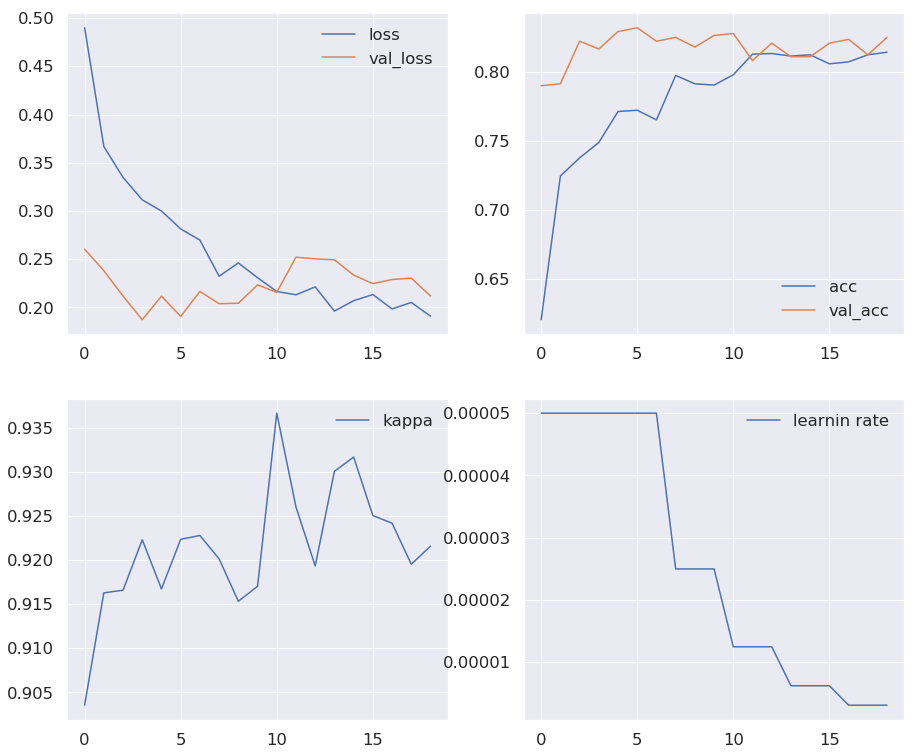

In [0]:
history_df = pd.DataFrame(history.history) 

fig=plt.figure(figsize=(15, 13))

fig.add_subplot(2, 2, 1)
plt.plot(history_df[['loss', 'val_loss']]) 
plt.legend(['loss', 'val_loss'])

fig.add_subplot(2, 2, 2)
plt.plot(history_df[['acc', 'val_acc']]) 
plt.legend(['acc', 'val_acc'])

fig.add_subplot(2, 2, 3)
plt.plot(qwk.val_kappas) 
plt.legend(['kappa'])

fig.add_subplot(2, 2, 4)
plt.plot(history_df['lr']) 
plt.legend(['learnin rate'])

# Prediction & TTA

In [0]:
from functools import partial
from collections import Counter

class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4

        ll = cohen_kappa_score(y, X_p, weights='quadratic')
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = scipy.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def coefficients(self):
        return self.coef_['x']

In [0]:
# Place holder for diagnosis column
test_df['diagnosis'] = np.zeros(test_df.shape[0]) 

test_gen = val_datagen().flow_from_dataframe(dataframe=test_df,
                                                directory=test_path,
                                                x_col='id_code',
                                                y_col='diagnosis',
                                                target_size= (SIZE,SIZE),
                                                color_mode='rgb',
                                                class_mode='other',
                                                batch_size=BATCH_SIZE,
                                                shuffle=False)

Found 1928 validated image filenames.


In [0]:
model.load_weights(model_name)

val_gen.reset()
y_val_preds, val_labels = get_preds_and_labels(model, val_gen)

# validation set을 이용해 각 class에 대한 kappa score계산
# kappa를 기준으로 각 class에 대한 threshold 설정(coefficients). 
optR = OptimizedRounder()
optR.fit(y_val_preds, val_labels)
coefficients=optR.coefficients()

In [0]:
tta_steps = 7
preds_tta = []

for i in tqdm(range(tta_steps)):
    y_test, _ = get_preds_and_labels(model, test_gen)
    yhat = optR.predict(y_test, coefficients).astype(np.uint8)  # 예측값을 coefficitent를 기준으로 교정한다.
    preds_tta.append(yhat)
    test_gen.reset()

In [0]:
preds_tta[0]

array([1, 4, 2, ..., 2, 2, 2], dtype=uint8)

In [0]:
final_yhat = np.mean(preds_tta, axis=0).astype(np.uint8)
final_yhat.shape

(1928,)

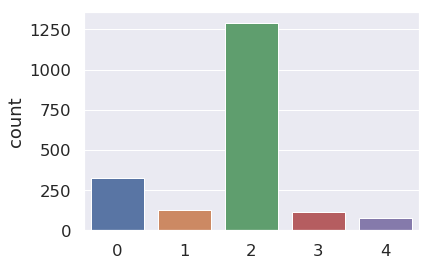

In [0]:
sns.countplot(final_yhat.ravel())

In [0]:
test_df['diagnosis'] = final_yhat
# Remove .png from ids
test_df['id_code'] = test_df['id_code'].str.replace(r'.png$', '')

In [0]:
test_df.head()

,id_code,diagnosis
0,0005cfc8afb6,1
1,003f0afdcd15,4
2,006efc72b638,2
3,00836aaacf06,2
4,009245722fa4,2


In [0]:
test_df.to_csv('submission.csv', index=False)